Proyecto Electrico

                            Escuela de Ingenieria Electrica

                            LabCes

                            Titulo: Implementacion de Analog Ensembles para prediccion de irradiancia solar.

                            Estudiante: Elsa Valeria Roman Astua
                                
                            Carnet: C26910

                            Profesor: Fausto Calderon Obaldia

                            Version: 02

                            Descripción:

                            Este código carga datos históricos de
                            irradiancia solar, genera predictores
                            basados en la hora y el día del año,
                            entrena un modelo tipo Analog Ensemble
                           (AnEn) y permite realizar un pronóstico a
                           1 hora ingresando una fecha y hora,
                           mostrando además la ventana temporal del
                           ensemble en una gráfica.

Mounted at /content/drive

--- Estructuración de datos ---
Datos preparados: 109687 pares válidos.
Estandarización completada.
Fecha (YYYY-MM-DD): 2026-05-31
Hora (HH:MM): 14:00


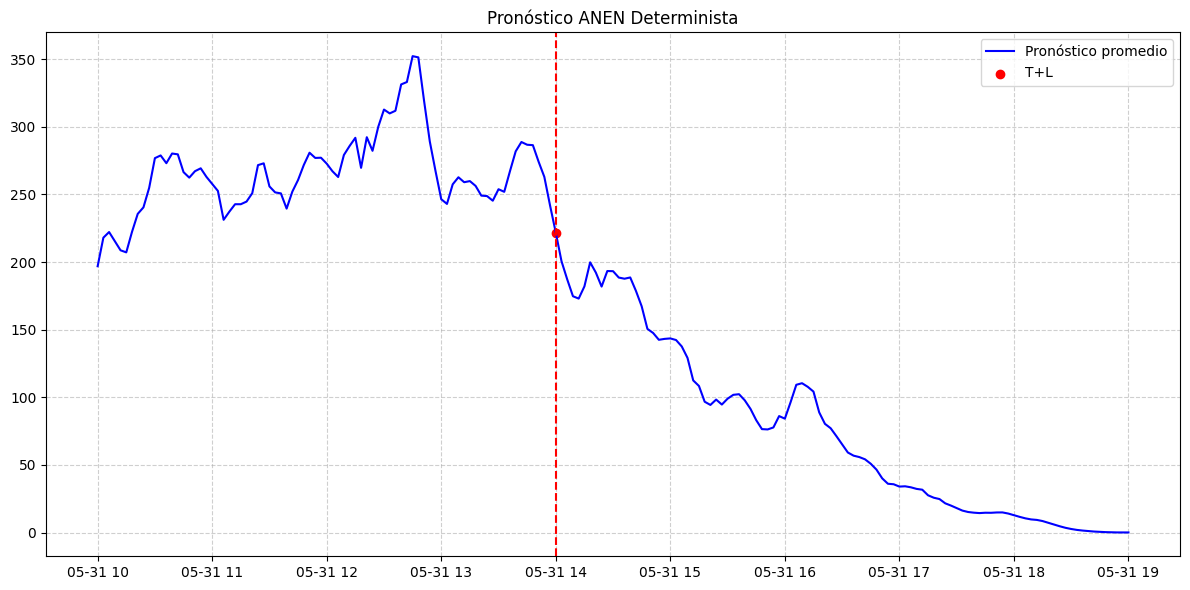


Irradiancia prevista: 221.75 W/m²


In [2]:
# Importación de librerías y montaje de Drive
!pip install matplotlib
import pandas as pd
import numpy as np
import os
from google.colab import drive
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Configuración general del sistema y parámetros del modelo
drive.mount('/content/drive')
INPUT_FOLDER = '/content/drive/MyDrive/Datos Filtrados/'
TIME_COLUMN = 'timestamp'
TARGET_COLUMN = 'solar'
L = 20
RESAMPLE_FREQ_MINUTES = 3
L_minutes = L * RESAMPLE_FREQ_MINUTES
PREDICTOR_COLUMNS_SIMPLE = ['Hour_sin', 'Day_of_Year_sin']
WINDOW_HALF_HOURS = 4
WINDOW_STEPS = WINDOW_HALF_HOURS * (60 // RESAMPLE_FREQ_MINUTES)

# Variables globales del modelo
F_hist_np = None
O_hist_np = None
predictor_names = PREDICTOR_COLUMNS_SIMPLE
mu = sigma = F_hist_standardized = None

def get_user_input(prompt_text):
    return input(prompt_text).strip()

# Construcción del historial, ingeniería de características y creación de ventanas
def combine_and_structure_data_windowed(folder_path, target_col, L):
    global F_hist_np, O_hist_np
    all_data = []
    print("\n--- Estructuración de datos ---")

    for filename in os.listdir(folder_path):
        if filename.endswith("_filtrado.csv"):
            df = pd.read_csv(os.path.join(folder_path, filename),
                             index_col=TIME_COLUMN, parse_dates=True)
            all_data.append(df)

    if not all_data:
        raise FileNotFoundError("No se encontraron archivos filtrados.")

    df_historia = (pd.concat(all_data)
                     .sort_index()
                     .loc[lambda x: ~x.index.duplicated()]
                     .dropna())

    # Features deterministas
    df_historia['Hour'] = df_historia.index.hour + df_historia.index.minute / 60
    df_historia['DayOfYear'] = df_historia.index.dayofyear
    df_historia['Hour_sin'] = np.sin(2*np.pi*df_historia['Hour']/24)
    df_historia['Day_of_Year_sin'] = np.sin(2*np.pi*df_historia['DayOfYear']/365)

    # Construcción de ventanas del target
    O_list = []
    N = len(df_historia)
    start_idx = WINDOW_STEPS
    end_idx = N - (L + WINDOW_STEPS)

    for i in range(start_idx, end_idx):
        w_start = i - WINDOW_STEPS
        w_end = i + L + WINDOW_STEPS + 1
        O_list.append(df_historia[target_col].iloc[w_start:w_end].values)

    O_hist_np = np.array(O_list)
    F_hist = df_historia[PREDICTOR_COLUMNS_SIMPLE].iloc[start_idx:end_idx]

    # Ajuste de tamaños
    m = min(len(F_hist), len(O_hist_np))
    F_hist_np = F_hist.iloc[:m].values
    O_hist_np = O_hist_np[:m]

    print(f"Datos preparados: {m} pares válidos.")

# Estandarización del modelo
def train_model_standardize_simple():
    """Estandariza los predictores deterministas."""
    global mu, sigma, F_hist_standardized

    mu = np.mean(F_hist_np, axis=0)
    sigma = np.where(np.std(F_hist_np, axis=0) == 0, 1, np.std(F_hist_np, axis=0))
    F_hist_standardized = (F_hist_np - mu) / sigma

    print("Estandarización completada.")

# Generación de F_t con características deterministas
def create_Ft_simple(target_datetime, L_minutes):
    """Genera el vector F_t usando hora y día del año."""
    input_dt = target_datetime - timedelta(minutes=L_minutes)
    hour = input_dt.hour + input_dt.minute / 60
    day = input_dt.timetuple().tm_yday
    return np.array([np.sin(2*np.pi*hour/24), np.sin(2*np.pi*day/365)])

# Predicción ANEN simplificada
def make_prediction_anen(F_t_nuevo, M=75):
    F_t_std = (F_t_nuevo - mu) / sigma
    dist = np.sqrt(np.sum((F_t_std - F_hist_standardized)**2, axis=1))
    idx = np.argsort(dist)[:M]
    ensemble = O_hist_np[idx]

    pred_idx = WINDOW_STEPS
    return {
        "mean_forecast": np.mean(ensemble, axis=0)[pred_idx],
        "uncertainty_range": (
            np.percentile(ensemble[:, pred_idx], 5),
            np.percentile(ensemble[:, pred_idx], 95)
        ),
        "ensemble_members": ensemble
    }

# Gráfica de la ventana temporal del pronóstico
def plot_prediction_window(ensemble, target_datetime):
    mean = np.mean(ensemble, axis=0)
    times = pd.date_range(
        start=target_datetime - timedelta(minutes=WINDOW_STEPS*RESAMPLE_FREQ_MINUTES),
        periods=len(mean),
        freq=f"{RESAMPLE_FREQ_MINUTES}min"
    )

    plt.figure(figsize=(12,6))
    plt.plot(times, mean, color='blue', label='Pronóstico promedio')
    plt.scatter(target_datetime, mean[WINDOW_STEPS], color='red', label='T+L')
    plt.axvline(target_datetime, color='red', linestyle='--')
    plt.title("Pronóstico ANEN Determinista")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Ejecución interactiva
def run_interactive_prediction_windowed(_):
    date = get_user_input("Fecha (YYYY-MM-DD): ")
    hour = get_user_input("Hora (HH:MM): ")
    target_dt = datetime.strptime(f"{date} {hour}", "%Y-%m-%d %H:%M")

    F_t = create_Ft_simple(target_dt, L_minutes)
    pred = make_prediction_anen(F_t, M=50)

    plot_prediction_window(pred["ensemble_members"], target_dt)
    print(f"\nIrradiancia prevista: {pred['mean_forecast']:.2f} W/m²")

# Orquestación del sistema
try:
    combine_and_structure_data_windowed(INPUT_FOLDER, TARGET_COLUMN, L)
    train_model_standardize_simple()
    run_interactive_prediction_windowed(predictor_names)
except Exception as e:
    print(f"Error en la ejecución: {e}")
